<a href="https://colab.research.google.com/github/abhipsitabose/LTC-Rota-Optimisation/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# ==============================
# Dissertation Results & Evaluation (Polished Version)
# ==============================

# --- STEP 1: Install dependencies ---
!pip install seaborn matplotlib pandas scipy

# --- STEP 2: Upload results file ---
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, kruskal

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print("File loaded successfully")
print(df.head())

Saving results_summary.csv to results_summary (2).csv
File loaded successfully
   staff_size  absence_rate preference_level  agency_multiplier  mip_coverage  \
0          50          0.05              low                1.5     92.156863   
1          50          0.05              low                2.0     92.156863   
2          50          0.05           medium                1.5     92.156863   
3          50          0.05           medium                2.0     92.156863   
4          50          0.05             high                1.5     92.156863   

   mip_cost  mip_pref_hit_rate  mip_fairness_std  mip_overtime_hours  \
0    124520           2.416918         49.435937                   0   
1    124520           2.719033         49.383067                   0   
2    124520           2.416918         49.435937                   0   
3    124520           2.719033         49.383067                   0   
4    124520           2.416918         49.435937                   0   

 

In [44]:
# --- STEP 3: Global Style ---
# Helper function for barplot with bold labels

def barplot_with_labels(data, x, y, hue=None, title="", ylabel="", xlabel="", fmt="%.1f", ylim=None):
    plt.figure(figsize=(9,6))
    if hue:
        ax = sns.barplot(data=data, x=x, y=y, hue=hue, palette=palette, errorbar=None)
    else:
        ax = sns.barplot(data=data, x=x, y=y, color="#1f77b4", errorbar=None)  # single blue bars
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt, fontsize=11, weight="bold", color="black")
    plt.title(title, fontsize=14, weight="bold")
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()


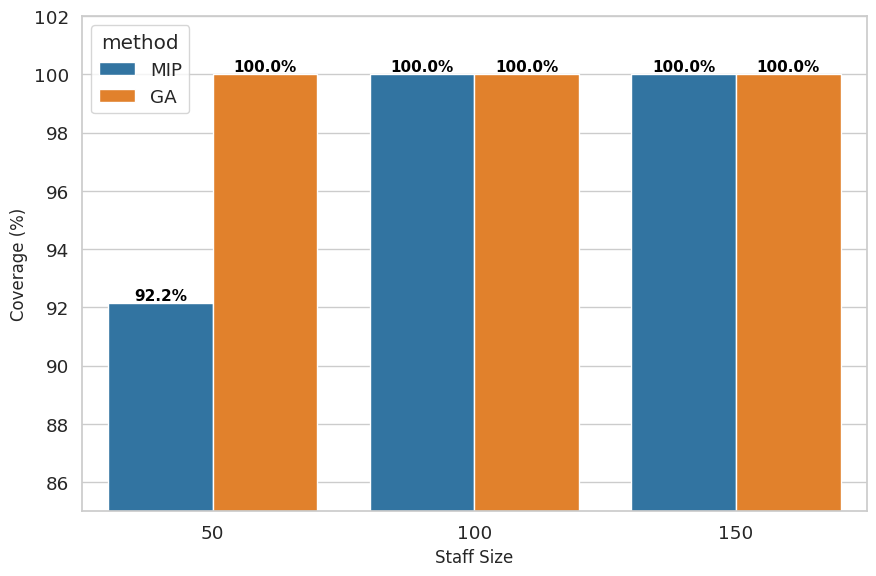

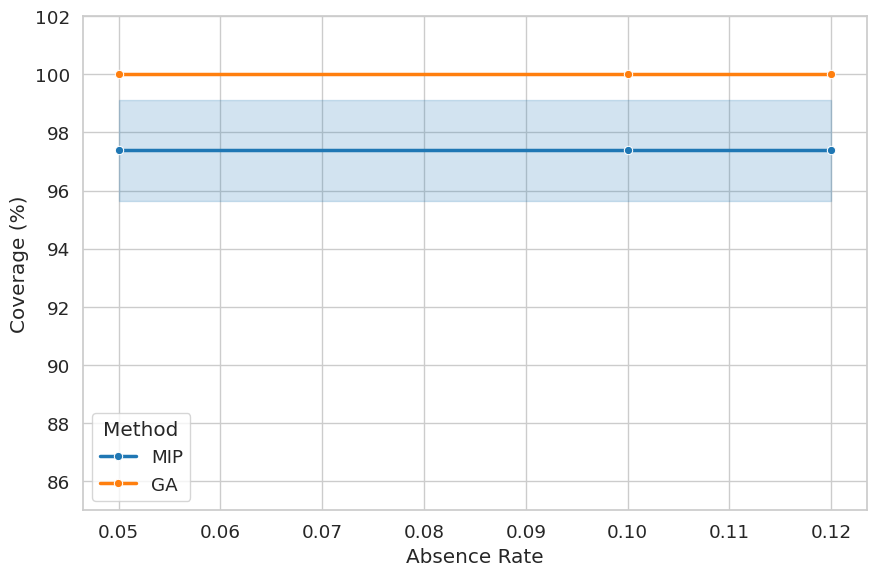

Coverage Comparison (MIP vs GA): t=-5.15, p=0.0000


In [30]:

# ==============================
# 1. Coverage
# ==============================

df_cov = df.melt(id_vars=["staff_size"],
                 value_vars=["mip_coverage","ga_coverage"],
                 var_name="method", value_name="coverage"
).replace({"mip_coverage":"MIP","ga_coverage":"GA"})

barplot_with_labels(df_cov,
                    x="staff_size", y="coverage", hue="method",

                    ylabel="Coverage (%)", xlabel="Staff Size",
                    fmt="%.1f%%", ylim=(85,102))

# ==============================
# 2. Robustness: Coverage vs Absence
# ==============================
plt.figure(figsize=(9,6))
sns.lineplot(data=df, x="absence_rate", y="mip_coverage",
             marker="o", label="MIP", color=palette["MIP"], linewidth=2.5)
sns.lineplot(data=df, x="absence_rate", y="ga_coverage",
             marker="o", label="GA", color=palette["GA"], linewidth=2.5)
plt.ylabel("Coverage (%)")
plt.xlabel("Absence Rate")
plt.ylim(85,102)
plt.legend(title="Method")
plt.tight_layout()
plt.show()

# ==============================
# Statistical Test: Coverage
# ==============================
from scipy.stats import ttest_rel

t_cov, p_cov = ttest_rel(df["mip_coverage"], df["ga_coverage"])
print(f"Coverage Comparison (MIP vs GA): t={t_cov:.2f}, p={p_cov:.4f}")

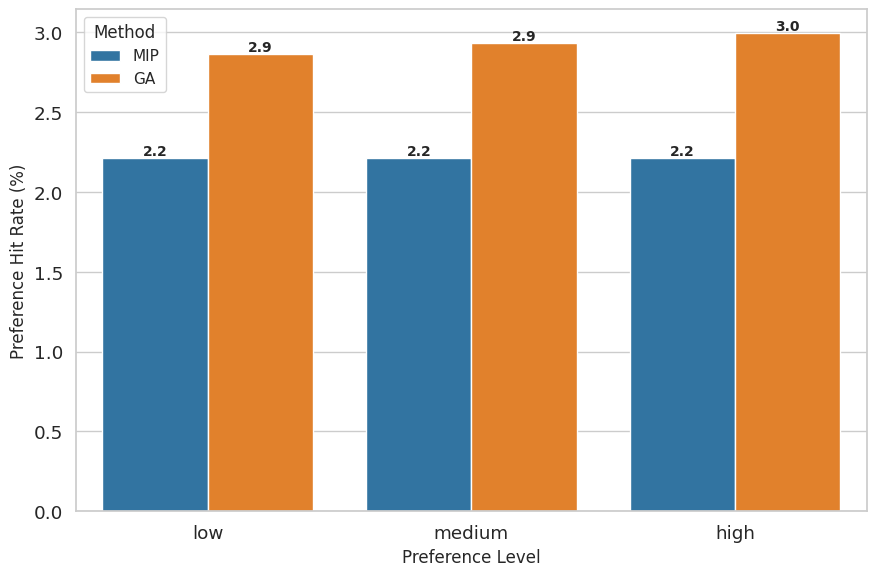

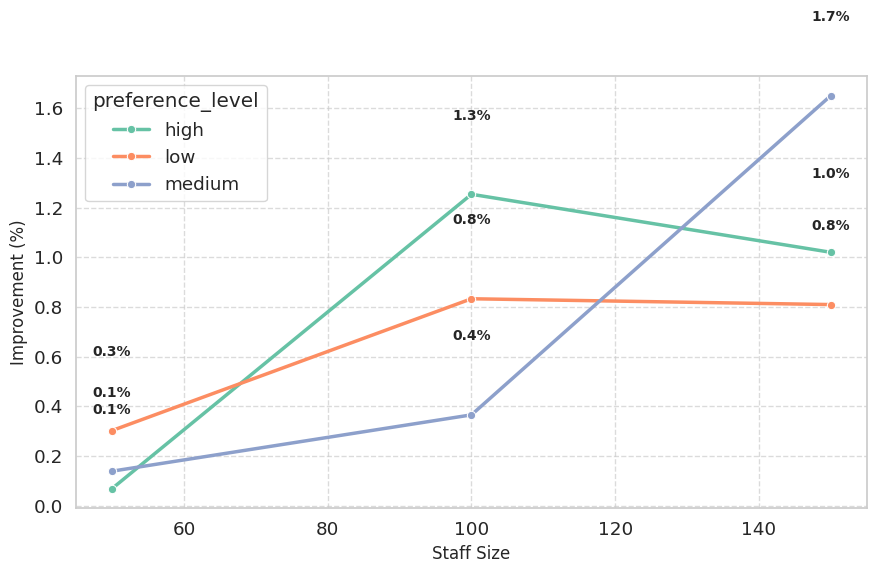

Preference Satisfaction (MIP vs GA): t=-7.53, p=0.0000
Kruskal-Wallis across preference levels: H=0.30, p=0.8625


In [49]:
# ==============================
# 2. Preference Satisfaction
# ==============================

from scipy.stats import ttest_rel, kruskal

# --- Ensure improvement column exists ---
if "pref_improvement_pct" not in df.columns:
    df["pref_improvement_pct"] = df["ga_pref_hit_rate"] - df["mip_pref_hit_rate"]

# 1. Preference Hit Rate (MIP vs GA)

df_pref = df.melt(id_vars=["staff_size","preference_level"],
                  value_vars=["mip_pref_hit_rate","ga_pref_hit_rate"],
                  var_name="method", value_name="pref_hit_rate")

df_pref["method"] = df_pref["method"].replace({
    "mip_pref_hit_rate": "MIP",
    "ga_pref_hit_rate": "GA"
})

plt.figure(figsize=(9,6))
ax = sns.barplot(data=df_pref, x="preference_level", y="pref_hit_rate",
                 hue="method", palette={"MIP":"#1f77b4","GA":"#ff7f0e"}, errorbar=None)

# Annotate values on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, weight="bold")


plt.ylabel("Preference Hit Rate (%)", fontsize=12)
plt.xlabel("Preference Level", fontsize=12)
plt.legend(title="Method", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

# 2. Preference Improvement (GA vs MIP)

df_pref_improve = df.groupby(["staff_size","preference_level"])["pref_improvement_pct"].mean().reset_index()

plt.figure(figsize=(9,6))
ax = sns.lineplot(data=df_pref_improve, x="staff_size", y="pref_improvement_pct",
                  hue="preference_level", marker="o", linewidth=2.5, palette="Set2")

# Annotate averaged values
for i, row in df_pref_improve.iterrows():
    ax.text(row["staff_size"], row["pref_improvement_pct"]+0.3,
            f"{row['pref_improvement_pct']:.1f}%",
            ha="center", fontsize=10, weight="bold")


plt.ylabel("Improvement (%)", fontsize=12)
plt.xlabel("Staff Size", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Statistical Tests

# Paired t-test: overall GA vs MIP preference hit rate
t_pref, p_pref = ttest_rel(df["mip_pref_hit_rate"], df["ga_pref_hit_rate"])
print(f"Preference Satisfaction (MIP vs GA): t={t_pref:.2f}, p={p_pref:.4f}")

# Kruskal-Wallis: check if improvements differ by preference level
groups = [df[df["preference_level"]==lvl]["pref_improvement_pct"]
          for lvl in df["preference_level"].unique()]
kw_stat, kw_p = kruskal(*groups)
print(f"Kruskal-Wallis across preference levels: H={kw_stat:.2f}, p={kw_p:.4f}")




/tmp/ipython-input-2428725267.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_pref, x="preference_level", y="pref_hit_rate",


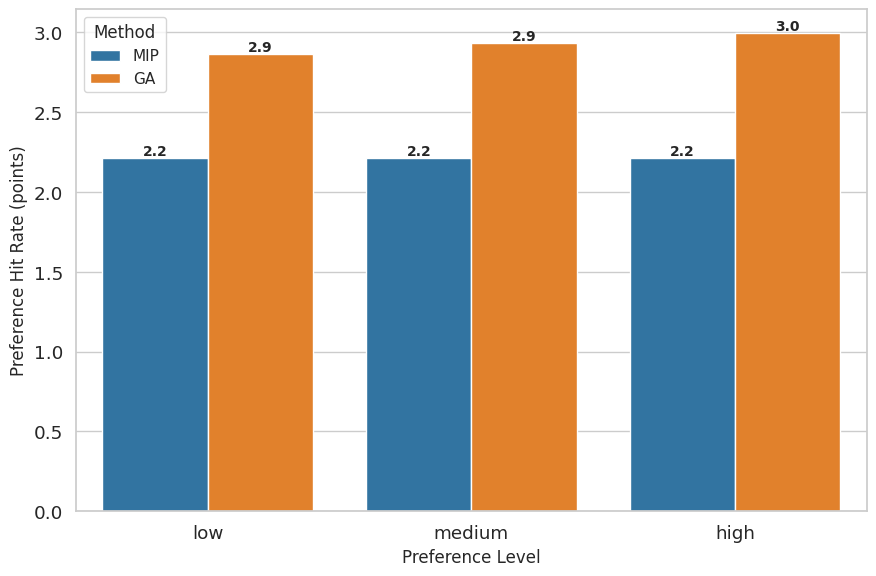

/tmp/ipython-input-2428725267.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x="preference_level", y="pref_abs_improve", color="lightgreen", ci=None)


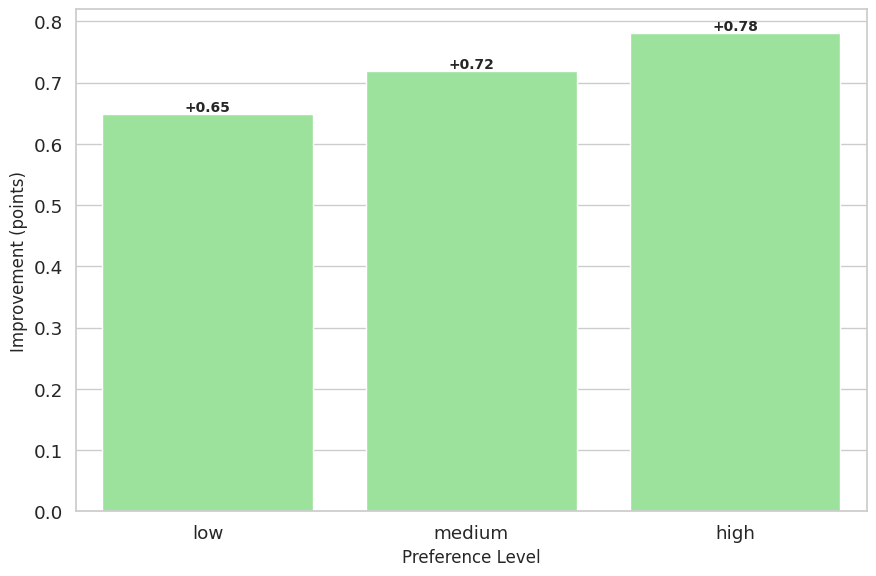

/tmp/ipython-input-2428725267.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x="preference_level", y="pref_rel_improve", color="skyblue", ci=None)


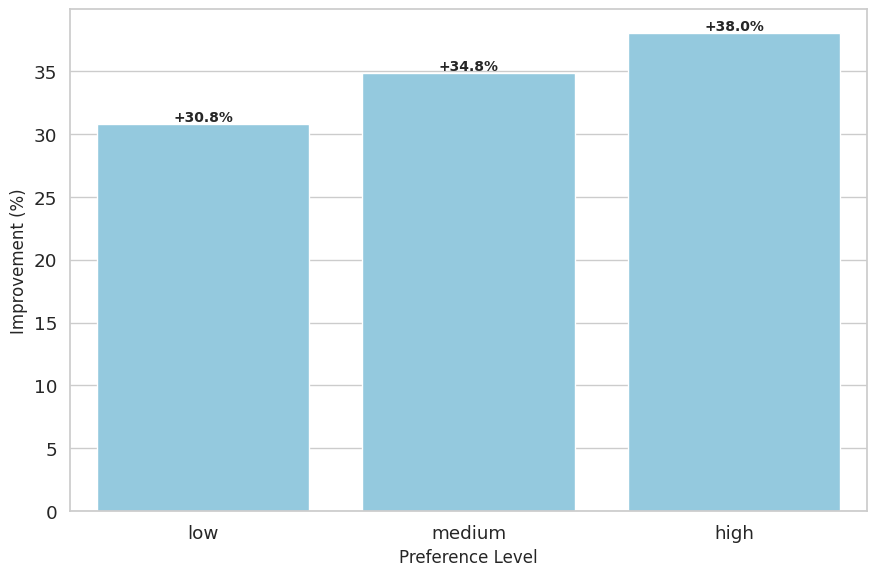

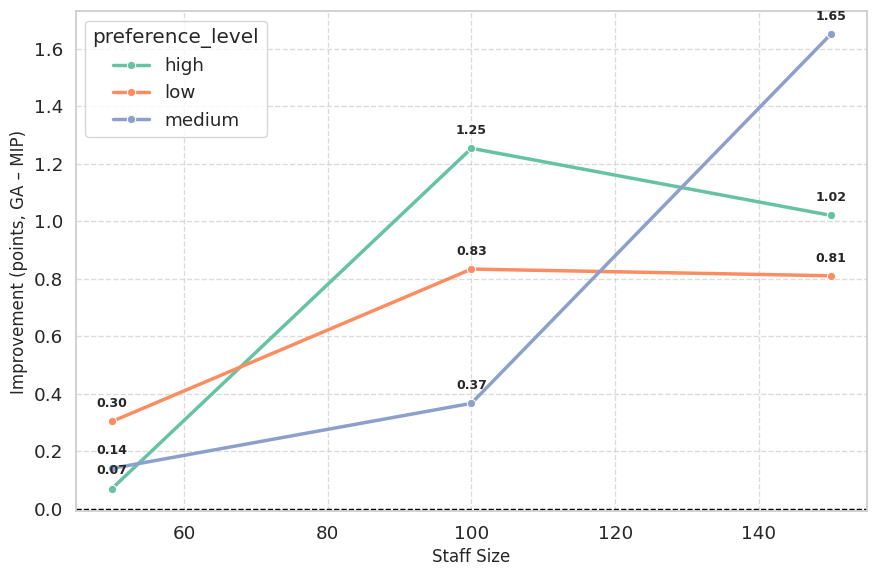

Paired t-test (MIP vs GA preference satisfaction): t=-7.53, p=0.0000
Kruskal-Wallis across preference levels: H=0.30, p=0.8625


In [54]:
# ==============================
# Preference Satisfaction Analysis
# ==============================


# Ensure improvement columns exist
df["pref_abs_improve"] = df["ga_pref_hit_rate"] - df["mip_pref_hit_rate"]
df["pref_rel_improve"] = (df["pref_abs_improve"] / df["mip_pref_hit_rate"]) * 100

palette = {"MIP":"#1f77b4","GA":"#ff7f0e"}


# Preference Hit Rate (MIP vs GA)

df_pref = df.melt(id_vars=["preference_level"],
                  value_vars=["mip_pref_hit_rate","ga_pref_hit_rate"],
                  var_name="method", value_name="pref_hit_rate")

df_pref["method"] = df_pref["method"].replace({
    "mip_pref_hit_rate":"MIP", "ga_pref_hit_rate":"GA"
})

plt.figure(figsize=(9,6))
ax = sns.barplot(data=df_pref, x="preference_level", y="pref_hit_rate",
                 hue="method", palette=palette, ci=None)

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, weight="bold")


plt.ylabel("Preference Hit Rate (points)", fontsize=12)
plt.xlabel("Preference Level", fontsize=12)
plt.legend(title="Method", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


#  Absolute Improvement (GA – MIP)

plt.figure(figsize=(9,6))
ax = sns.barplot(data=df, x="preference_level", y="pref_abs_improve", color="lightgreen", ci=None)

for container in ax.containers:
    ax.bar_label(container, fmt="+%.2f", fontsize=10, weight="bold")


plt.ylabel("Improvement (points)", fontsize=12)
plt.xlabel("Preference Level", fontsize=12)
plt.tight_layout()
plt.show()


# Relative Improvement (%)

plt.figure(figsize=(9,6))
ax = sns.barplot(data=df, x="preference_level", y="pref_rel_improve", color="skyblue", ci=None)

for container in ax.containers:
    ax.bar_label(container, fmt="+%.1f%%", fontsize=10, weight="bold")

plt.ylabel("Improvement (%)", fontsize=12)
plt.xlabel("Preference Level", fontsize=12)
plt.tight_layout()
plt.show()


# Improvement Robustness (by staff size & preference level)

df_pref_improve = df.groupby(["staff_size","preference_level"])["pref_abs_improve"].mean().reset_index()

plt.figure(figsize=(9,6))
ax = sns.lineplot(data=df_pref_improve, x="staff_size", y="pref_abs_improve",
                  hue="preference_level", marker="o", linewidth=2.5, palette="Set2")

for i, row in df_pref_improve.iterrows():
    ax.text(row["staff_size"], row["pref_abs_improve"]+0.05,
            f"{row['pref_abs_improve']:.2f}", ha="center", fontsize=9, weight="bold")

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.ylabel("Improvement (points, GA – MIP)", fontsize=12)
plt.xlabel("Staff Size", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------
# Statistical Tests
# ------------------------------
t_pref, p_pref = ttest_rel(df["mip_pref_hit_rate"], df["ga_pref_hit_rate"])
groups = [df[df["preference_level"]==lvl]["pref_abs_improve"] for lvl in df["preference_level"].unique()]
kw_stat, kw_p = kruskal(*groups)

print(f"Paired t-test (MIP vs GA preference satisfaction): t={t_pref:.2f}, p={p_pref:.4f}")
print(f"Kruskal-Wallis across preference levels: H={kw_stat:.2f}, p={kw_p:.4f}")


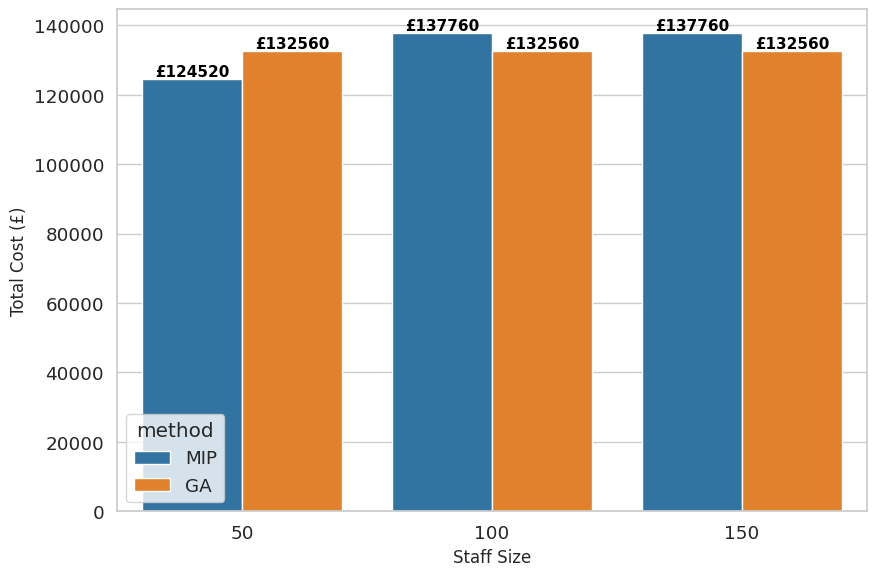

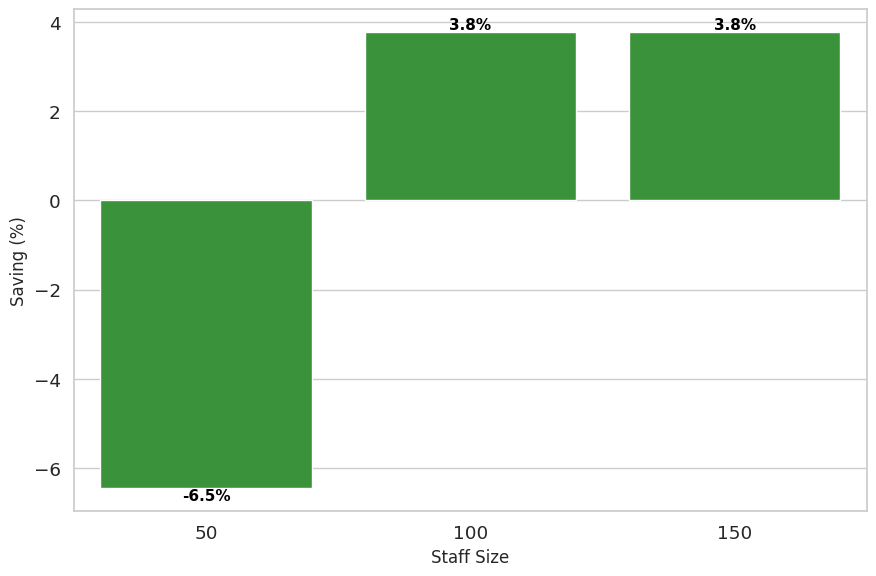

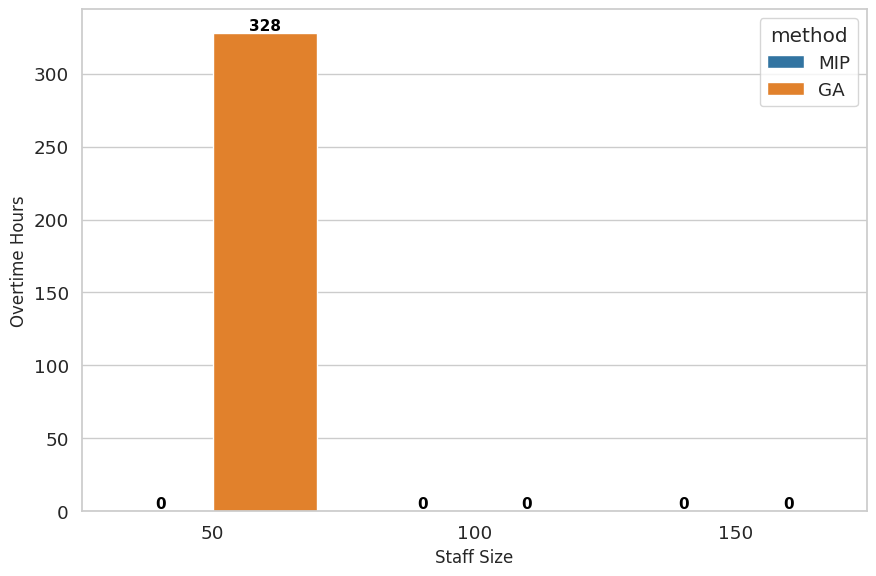

Total Cost (MIP vs GA): t=0.92, p=0.3630
Overtime Hours (MIP vs GA): t=-5.14, p=0.0000


In [35]:
# ==============================
# 3. Cost
# ==============================

# --- 1. Total Cost by Method and Staff Size ---
df_cost = df.melt(id_vars=["staff_size","absence_rate"],
                  value_vars=["mip_cost","ga_cost"],
                  var_name="method", value_name="total_cost")
df_cost["method"] = df_cost["method"].replace({"mip_cost":"MIP","ga_cost":"GA"})

barplot_with_labels(df_cost, x="staff_size", y="total_cost", hue="method",

                    ylabel="Total Cost (£)", xlabel="Staff Size", fmt="£%.0f")


# --- 2. Agency Cost Saving % (GA vs MIP) ---
# Agency Cost Saving % (single-colour plot)
plt.figure(figsize=(9,6))
ax = sns.barplot(data=df, x="staff_size", y="agency_cost_saving_pct",
                 color="#2ca02c", errorbar=None)  # green

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", fontsize=11, weight="bold", color="black")

plt.ylabel("Saving (%)", fontsize=12)
plt.xlabel("Staff Size", fontsize=12)
plt.tight_layout()
plt.show()


# --- 3. Overtime Hours by Method and Staff Size ---
df_ot = df.melt(id_vars=["staff_size","absence_rate"],
                value_vars=["mip_overtime_hours","ga_overtime_hours"],
                var_name="method", value_name="overtime_hours")
df_ot["method"] = df_ot["method"].replace({"mip_overtime_hours":"MIP","ga_overtime_hours":"GA"})

barplot_with_labels(df_ot, x="staff_size", y="overtime_hours", hue="method",

                    ylabel="Overtime Hours", xlabel="Staff Size", fmt="%.0f")


# --- 4. Statistical Tests ---
t_cost, p_cost = ttest_rel(df["mip_cost"], df["ga_cost"])
t_ot, p_ot = ttest_rel(df["mip_overtime_hours"], df["ga_overtime_hours"])

print(f"Total Cost (MIP vs GA): t={t_cost:.2f}, p={p_cost:.4f}")
print(f"Overtime Hours (MIP vs GA): t={t_ot:.2f}, p={p_ot:.4f}")


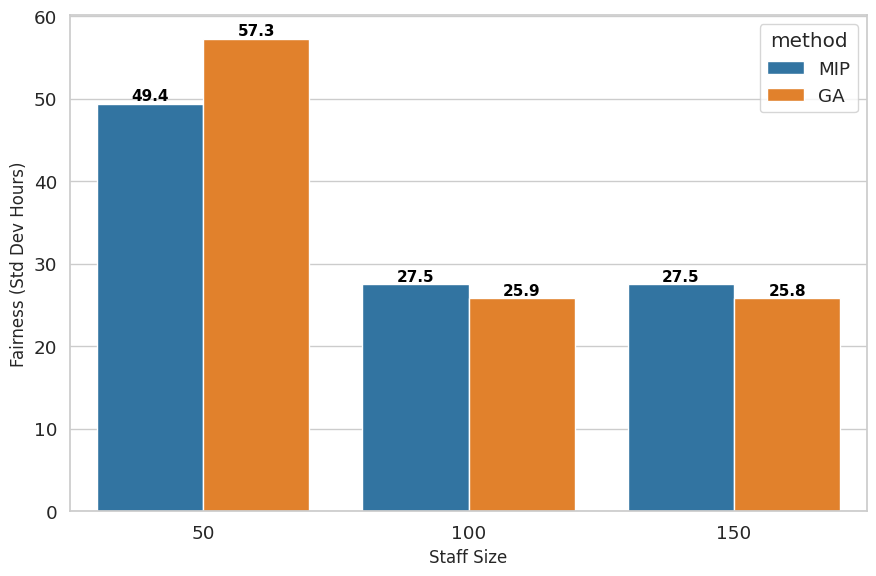

Fairness Comparison (MIP vs GA): t=-2.44, p=0.0182


In [39]:

# ==============================
# 4. Fairness (Std Dev Hours)
# ==============================
df_fair = df.melt(id_vars=["staff_size"],
                  value_vars=["mip_fairness_std","ga_fairness_std"],
                  var_name="method", value_name="fairness"
).replace({"mip_fairness_std":"MIP","ga_fairness_std":"GA"})

barplot_with_labels(df_fair, x="staff_size", y="fairness", hue="method",
                   ylabel="Fairness (Std Dev Hours)", xlabel="Staff Size", fmt="%.1f")

t_fair, p_fair = ttest_rel(df["mip_fairness_std"], df["ga_fairness_std"])
print(f"Fairness Comparison (MIP vs GA): t={t_fair:.2f}, p={p_fair:.4f}")



/tmp/ipython-input-3168807902.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_runtime, x="staff_size", y="runtime_sec",


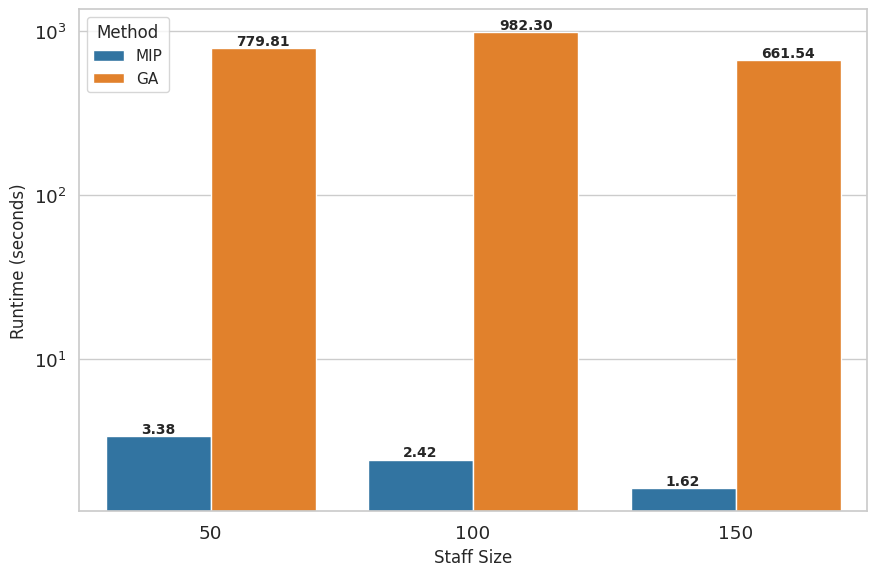

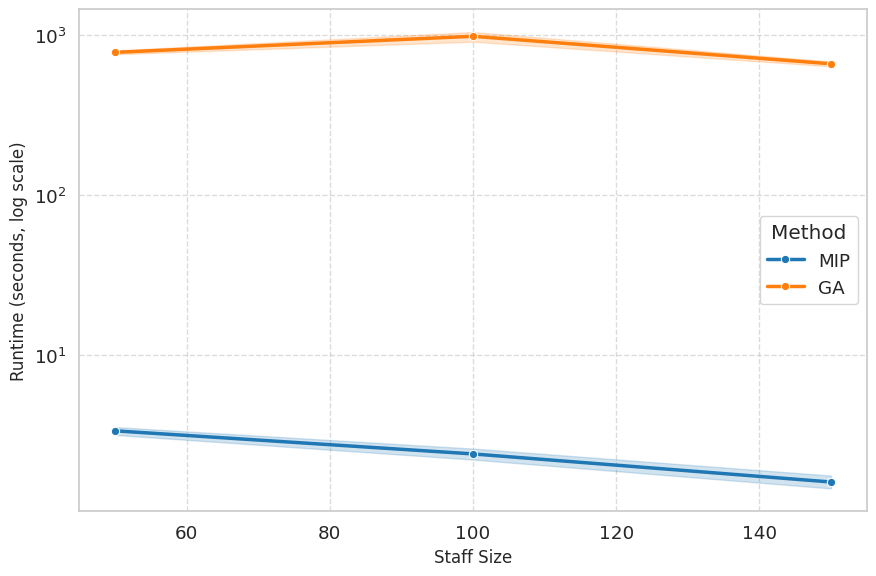

Runtime Comparison (MIP vs GA): t=-35.81, p=0.0000


In [57]:
# ==============================
# 5. Runtime
# ==============================

# Reshape runtime data
df_runtime = df.melt(id_vars=["staff_size"],
                     value_vars=["mip_runtime_sec","ga_runtime_sec"],
                     var_name="method", value_name="runtime_sec")

df_runtime["method"] = df_runtime["method"].replace({
    "mip_runtime_sec":"MIP", "ga_runtime_sec":"GA"
})


# Figure 19: Runtime Comparison (MIP vs GA, grouped bars)

plt.figure(figsize=(9,6))
ax = sns.barplot(data=df_runtime, x="staff_size", y="runtime_sec",
                 hue="method", palette={"MIP":"#1f77b4","GA":"#ff7f0e"}, ci=None)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=10, weight="bold")

plt.ylabel("Runtime (seconds)", fontsize=12)
plt.xlabel("Staff Size", fontsize=12)
plt.yscale("log")  # log scale for visibility
plt.legend(title="Method", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


# Runtime Scalability (line plot)

plt.figure(figsize=(9,6))
sns.lineplot(data=df, x="staff_size", y="mip_runtime_sec", marker="o", label="MIP", linewidth=2.5, color="#1f77b4")
sns.lineplot(data=df, x="staff_size", y="ga_runtime_sec", marker="o", label="GA", linewidth=2.5, color="#ff7f0e")

plt.ylabel("Runtime (seconds, log scale)", fontsize=12)
plt.xlabel("Staff Size", fontsize=12)
plt.yscale("log")
plt.legend(title="Method")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Statistical Test

from scipy.stats import ttest_rel
t_run, p_run = ttest_rel(df["mip_runtime_sec"], df["ga_runtime_sec"])
print(f"Runtime Comparison (MIP vs GA): t={t_run:.2f}, p={p_run:.4f}")



